<a href="https://colab.research.google.com/github/MRdvan/Pytorch-Training/blob/master/Pytorch-fundamentals-to-deploy/03_PyTorch_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch Computer Vision


In [13]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

## Setup device agnostic-code

In [14]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Prepare Dataset

In [15]:
#FashionMNIST Data loading

train_data = torchvision.datasets.FashionMNIST(
    root = "data", # Where to download data to
    train = True, 
    download = True,
    transform = ToTensor(), #images come as PIL format, apply transform to change it to tensor
    target_transform = None # label transform part
)

test_data = torchvision.datasets.FashionMNIST(
    root = "data", # Where to download data to
    train = False, 
    download = True,
    transform = ToTensor(), #images come as PIL format, apply transform to change it to tensor
    target_transform = None # label transform part
)

In [16]:
image,label = train_data[0]

In [17]:
image.shape
#[color_channels=1, height=28, width=28]

torch.Size([1, 28, 28])

* PyTorch generally accepts NCHW (channels first) as the default for many operators.

* However, PyTorch also explains that NHWC (channels last) performs better

In [18]:
# How many samples are there? 
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [19]:
# See classes (its a multi-class classification)
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


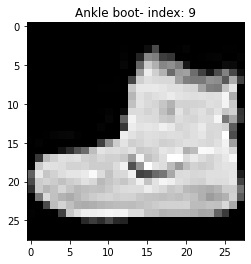

In [20]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(),cmap = "gray") # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(class_names[label] +"- index: " +str(label));


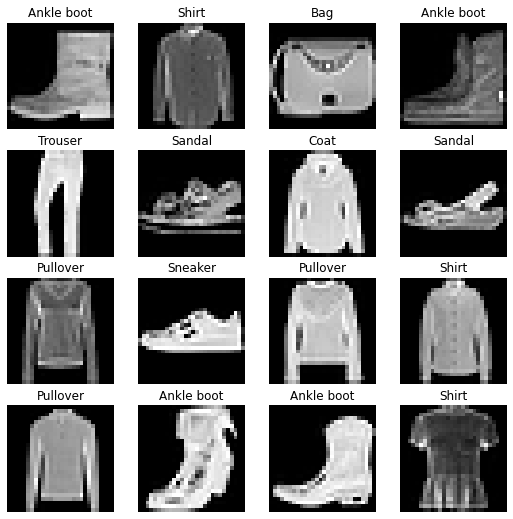

In [21]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

##Prepare DataLoader

In [22]:
from torch.utils.data import DataLoader

# Pick as power of 2 (8,16,32,...) less is better
BATCH_SIZE = 32

# Turn dataset into iterables 
train_dataloader = DataLoader(train_data,batch_size = BATCH_SIZE,shuffle = True)
test_dataloader = DataLoader(test_data,batch_size = BATCH_SIZE,shuffle = False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} total:{len(train_dataloader)*BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} total:{len(test_dataloader)*BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f34e7e9e6d0>, <torch.utils.data.dataloader.DataLoader object at 0x7f34e7e9e750>)
Length of train dataloader: 1875 batches of 32 total:60000
Length of test dataloader: 313 batches of 32 total:10016


In [23]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Building Base Model

* We are gonna build 2 linear layered simple model but difference between this model and previous builded models is we need  nn.Flatten() function at the first layer

In [24]:
# WHAT DOES FLATTEN FUNCTİON DO


flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


* The nn.Flatten() layer took our shape from[color_channels, height, width] to [color_channels, height*width]
* 784 is our input shape size

In [25]:
from torch import nn

class FashionModel(nn.Module):
  def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features = hidden_units),
        nn.Linear(in_features=hidden_units,out_features = output_shape)
    )
  def forward(self,x):
    return self.layers(x)

torch.manual_seed(42)
model = FashionModel(input_shape = 784,hidden_units = 10,output_shape = len(class_names))
model.to("cpu")

FashionModel(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [26]:
# Import accuracy metric
!pip install torchmetrics
from torchmetrics import F1Score
f1_score = F1Score(num_classes=10)
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs = 3
# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
      model.train()
      y_pred = model(X)
      loss = loss_fn(y_pred,y)
      train_loss += loss

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
      
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss ,test_acc = 0,0
    model.eval()
    with torch.inference_mode():
      for X,y in test_dataloader:
        test_pred = model(X)
        test_loss += loss_fn(test_pred,y)
        test_acc += f1_score(test_pred.argmax(dim=1),y)
      test_loss /= len(test_dataloader)
      test_acc /= len(test_dataloader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 0.82%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 0.83%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 0.83%



## Make predictions and get result

In [37]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               f1_score,
               device : torch.device = device):
    """Returns a dictionary containing the results of model predicting on data_loader."""

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += f1_score(y_pred.argmax(dim=1),y) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model, data_loader=test_dataloader,
    loss_fn=loss_fn, f1_score=f1_score
)
model_0_results


{'model_name': 'FashionModel',
 'model_loss': 0.47663894295692444,
 'model_acc': tensor(0.8343)}

## Setup device agnostic-code

In [29]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Model 2: Building a better model with non-linearity 

In [30]:
# Create a model with non-linear and linear layers
class FashionModel2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),# added
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() # added
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [31]:
torch.manual_seed(42)
model2 = FashionModel2(784,10,len(class_names)).to(device)
next(model2.parameters()).device

device(type='cpu')

In [32]:
# Import accuracy metric
!pip install torchmetrics
from torchmetrics import F1Score

# Setup loss function,accuracy and optimizer
f1_score = F1Score(num_classes=10)
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               f1_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += f1_fn(y_pred.argmax(dim=1),y) # Go from logits -> pred labels

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              f1_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            
            test_loss += loss_fn(test_pred, y)
            test_acc += f1_fn(test_pred.argmax(dim=1),y)# Go from logits -> pred labels
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [34]:
torch.manual_seed(42)

epochs = 3
for epoch in tqdm(range(epochs)):
  train_step(data_loader = train_dataloader,
             model = model2,
             loss_fn = loss_fn,
             optimizer = optimizer,
             f1_fn = f1_score,
             device = device)
  
  test_step(data_loader=test_dataloader,
        model=model2,
        loss_fn=loss_fn,
        f1_fn = f1_score)
  

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 1.09199 | Train accuracy: 0.61%
Test loss: 0.95636 | Test accuracy: 0.65%

Train loss: 0.78101 | Train accuracy: 0.72%
Test loss: 0.72227 | Test accuracy: 0.74%

Train loss: 0.67027 | Train accuracy: 0.76%
Test loss: 0.68500 | Test accuracy: 0.75%



In [38]:
torch.manual_seed(42)

# Note: This will error due to `eval_model()` not using device agnostic code 
model_1_results = eval_model(model=model2, 
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    f1_score=f1_score) 
model_1_results 

{'model_name': 'FashionModel2',
 'model_loss': 0.6850009560585022,
 'model_acc': tensor(0.7502)}

In [39]:
model_0_results

{'model_name': 'FashionModel',
 'model_loss': 0.47663894295692444,
 'model_acc': tensor(0.8343)}

* in this case, it looks like adding non-linearities to our model made it perform worse than the baseline.

Two of the main to fix overfitting include:

* Using a smaller or different model (some models fit certain kinds of data better than others).
* Using a larger dataset (the more data, the more chance a model has to learn generalizable patterns).

## Model 3: Building Convolutional Neural Network (CNN)

In [40]:
# Create a convolutional neural network 
class FashionModel3(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,out_channels = hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,out_channels = hidden_units,kernel_size = 3,stride = 1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    def forward(self,x:torch.Tensor):
      x = self.block_1(x)
      x = self.block_2(x)
      x = self.classifier(x)
      return x

torch.manual_seed(42)
model3 = FashionModel3(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)

model3

FashionModel3(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [41]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model3.parameters(), 
                             lr=0.1)

In [42]:
torch.manual_seed(42)

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model3, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        f1_fn=f1_score,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model3,
        loss_fn=loss_fn,
        f1_fn=f1_score,
        device=device
    )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59518 | Train accuracy: 0.78%
Test loss: 0.39500 | Test accuracy: 0.86%

Epoch: 1
---------
Train loss: 0.36536 | Train accuracy: 0.87%
Test loss: 0.35244 | Test accuracy: 0.87%

Epoch: 2
---------
Train loss: 0.32588 | Train accuracy: 0.88%
Test loss: 0.32719 | Test accuracy: 0.88%



In [44]:
# Get model_2 results 
model_2_results = eval_model(
    model=model3,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    f1_score=f1_score
)
model_2_results

{'model_name': 'FashionModel3',
 'model_loss': 0.32718968391418457,
 'model_acc': tensor(0.8807)}

In [45]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionModel,0.476639,tensor(0.8343)
1,FashionModel2,0.685001,tensor(0.7502)
2,FashionModel3,0.327190,tensor(0.8807)


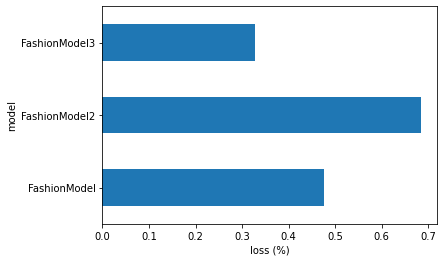

In [46]:
# Visualize our model results
compare_results.set_index("model_name")["model_loss"].plot(kind="barh")
plt.xlabel("loss (%)")
plt.ylabel("model");

## make and evaluate best model

In [47]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [48]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [49]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model3, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.4021e-06, 1.7343e-07, 4.4511e-07, 1.2103e-05, 5.4026e-07, 9.9938e-01,
         3.7154e-06, 2.1650e-04, 1.4199e-04, 2.4416e-04],
        [1.0080e-01, 5.6287e-01, 7.4506e-04, 1.1212e-01, 6.3881e-02, 3.0674e-04,
         1.5560e-01, 1.6463e-03, 1.0169e-03, 1.0133e-03]])

In [50]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [52]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

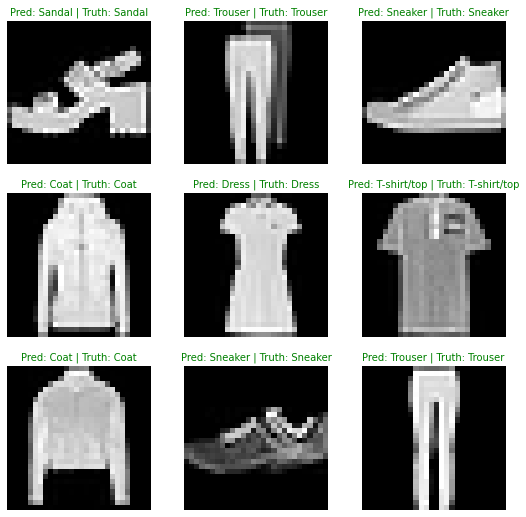

In [51]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

##Making a confusion Matrix

To make a confusion matrix, we'll go through three steps:

* Make predictions with our trained model, model_2 (a confusion matrix compares predictions to true labels).
* Make a confusion matrix using torch.ConfusionMatrix.
* Plot the confusion matrix using mlxtend.plotting.plot_confusion_matrix().

In [53]:
# 1. Make predictions with trained model
y_preds = []
model3.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model3(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [54]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.14.0
     |████████████████████████████████| 1.3 MB 29.4 MB/s 
mlxtend version: 0.14.0


In [56]:
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher


0.14.0


AssertionError: ignored

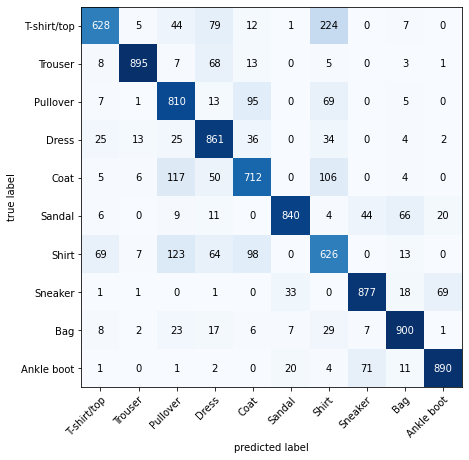

In [57]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with *NumPy* 
    class_names=class_names, # turn the row and column labels into *class names*
    figsize=(10, 7)
);

**!** The model gets most "confused" on classes that are similar, for example predicting "Pullover" for images that are actually labelled "Shirt".

**!** And the same for predicting "Shirt" for classes that are actually labelled "T-shirt/top".

In [59]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to:{MODEL_SAVE_PATH}")
torch.save(obj=model3.state_dict(),f=MODEL_SAVE_PATH)

Saving model to:models/03_pytorch_computer_vision_model_2.pth


In [61]:
#Create new model instance
loaded_model3 = FashionModel3(input_shape=1, 
                                    hidden_units=10, 
                                    output_shape=10) 
loaded_model3.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model3 = loaded_model3.to(device)

In [63]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model3_results = eval_model(
    model=loaded_model3,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    f1_score=f1_score
)

loaded_model3_results

{'model_name': 'FashionModel3',
 'model_loss': 0.32718968391418457,
 'model_acc': tensor(0.8807)}

In [64]:
model_2_results


{'model_name': 'FashionModel3',
 'model_loss': 0.32718968391418457,
 'model_acc': tensor(0.8807)}

In [65]:
#Check if the results are close to eachother
torch.isclose(torch.tensor(model_2_results["model_loss"]), 
              torch.tensor(loaded_model3_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)